# Aim of this Notebook

Predict (?) using Morgan fingerprints as a descriptor (?) and a few ML models

In [1]:
# RDKit packages
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Descriptors import _descList
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
#from rdkit.Chem import rdMolDescriptors as rdMD

# RDKit descriptors
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint, GetHashedAtomPairFingerprintAsBitVect
from rdkit.Chem.rdMolDescriptors import GetHashedTopologicalTorsionFingerprintAsBitVect
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from rdkit.Avalon.pyAvalonTools import GetAvalonFP 
from rdkit.Chem.AllChem import  GetMorganFingerprintAsBitVect, GetErGFingerprint
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import rdkit.DataStructs.cDataStructs

import pandas as pd
import numpy as np
import math
# Random number is 42!
np.random.seed(42)
#prng = np.random.RandomState(42) 

import pickle
import os
import math
from matplotlib import cm

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, explained_variance_score
from scipy.stats import spearmanr, pearsonr

from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection

#from xgboost import XGBRegressor
#import lightgbm as lgb

#from keras import regularizers
#from keras.models import Sequential
#from keras.layers import Dense, Activation, Dropout

import warnings
warnings.filterwarnings('ignore', '.*do not.*')

Data consists of https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system strings, which encode molecular graphs into a string of characters, and experimentally determined solubility values [1].

In [2]:
#Read data

data = pd.read_csv('Malaria Molecules 2019_09_09_one_hot_encoding.tsv', sep='\t', header=0)
data['ROMol'] = data['Canonical_Smiles'].apply(Chem.MolFromSmiles)

# Remove molecules that could not be parsed from SMILES
data = data[~data.ROMol.isnull()]

def calc_pIC50(x):
    return -np.log10(x*(10**-6))
        
#data.rename(columns={'LOGD_MEAN': 'logD'}, inplace=True)
data['pIC50'] = calc_pIC50(data['Value'])

# Target values
y = data['pIC50'].values

print(f"The data set contains {len(data)} compounds")

The data set contains 369 compounds


RDKit ERROR: [15:01:10] Explicit valence for atom # 21 C, 6, is greater than permitted
RDKit ERROR: [15:01:10] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [15:01:10] Explicit valence for atom # 21 C, 6, is greater than permitted


----
Dataset contains 1164 drug-like compounds.
Let's __visualize__ the _physchem_ properties of the training set's compounds!

In [3]:
data.describe()

,Value,PfaI EC50 (Inh),Pfal IC50 (GSK),Pfal IC50 (Syngene),Pfal IC50 (Dundee),Pfal IC50 (Avery),Pfal (K1) IC50 (Avery),Pfal IC50 (Ralph),Pfal IC50 (Guy),Pfal (K1) IC50 (Guy),...,ION_0,ION_1,ION_0.5,series_1,series_2,series_3,series_4,series_not4,series_TB,pIC50
count,369.000000,369.0,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,...,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000
mean,11.181782,0.0,0.108401,0.146341,0.487805,0.140921,0.010840,0.048780,0.010840,0.010840,...,0.086721,0.525745,0.013550,0.260163,0.002710,0.127371,0.588076,0.018970,0.002710,5.697095
std,15.078028,0.0,0.311308,0.353928,0.500530,0.348413,0.103691,0.215701,0.103691,0.103691,...,0.281808,0.500015,0.115771,0.439319,0.052058,0.333841,0.492850,0.136605,0.052058,1.044178
min,0.001000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.301030
25%,0.309000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.602060
50%,2.150000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.667562
75%,25.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.510042
max,50.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000


## Training dataset's description

The training dataset contains 369 organic compounds

----


In [5]:
print("Converting Morgan fingerprints")

# Morgan fingerprints, length 1024 bits
def Morgan_fingerprint(mol):
    fp = np.zeros((1,))
    ConvertToNumpyArray(GetMorganFingerprintAsBitVect(mol, 2, nBits = 1024), fp)
    return fp

data['fp_Morgan'] = data['ROMol'].apply(Morgan_fingerprint)

Converting Morgan fingerprints


I will use the Morgan fingerprint, as they result the lowest mean absolute error regression loss (most of the times...). 
A new data matrix *X* is created and then fed into machine learning models.

In [6]:
st = StandardScaler()
X = np.array(list(data['fp_Morgan']))

X_st = st.fit_transform(X)

print(X.shape)
print(X_st.shape)

(369, 1024)
(369, 1024)


### ML Gym area
Applying grid search to explore the hyperparameters of the RandomForestRegressor, LightGBMRegressor, GaussianProcessRegressor, and Kernel Ridge models in sklearn.

In [7]:
RFmodel = GridSearchCV(RandomForestRegressor(), cv=20,
                       param_grid={"n_estimators": np.linspace(10, 200, 25).astype('int')},
                       scoring='neg_mean_absolute_error', n_jobs=-1)

RFmodel = RFmodel.fit(X, y)
Best_RandomForestRegressor = RFmodel.best_estimator_

print("Best Random Forest model")
print('Best parameters found by grid search are:', RFmodel.best_params_)
print('Best score:', -1*RFmodel.best_score_)

/Users/btatsis/anaconda3/envs/comptoir/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Random Forest model
Best parameters found by grid search are: {'n_estimators': 112}
Best score: 0.5408733741655531


In [8]:
GPmodel = GridSearchCV(GaussianProcessRegressor(normalize_y=True), cv=20,
                       param_grid={"alpha": np.logspace(-15, -10, 30)}, 
                       scoring='neg_mean_absolute_error', n_jobs=-1)

GPmodel = GPmodel.fit(X, y)
Best_GaussianProcessRegressor = GPmodel.best_estimator_

print("Best Gaussian Process model")
print('Best parameters found by grid search are:', GPmodel.best_params_)
print('Best score:', -1*GPmodel.best_score_)

Best Gaussian Process model
Best parameters found by grid search are: {'alpha': 1.4873521072935117e-15}
Best score: 0.8977927768228827


/Users/btatsis/anaconda3/envs/comptoir/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [9]:
KRmodel = GridSearchCV(KernelRidge(), cv=20,
                       param_grid={"alpha": np.logspace(-10, -5, 10),
                                   "gamma": np.logspace(-12, -9, 10), "kernel" : ['laplacian', 'rbf']}, 
                       scoring='neg_mean_absolute_error', n_jobs=-1)

KRmodel = KRmodel.fit(X, y)
Best_KernelRidge = KRmodel.best_estimator_

print("Best Kernel Ridge model")
print('Best parameters found by grid search are:', KRmodel.best_params_)
print('Best score for Kernel Ridge model: ', -1*KRmodel.best_score_)

Best Kernel Ridge model
Best parameters found by grid search are: {'alpha': 1.2915496650148826e-09, 'gamma': 4.641588833612773e-11, 'kernel': 'laplacian'}
Best score for Kernel Ridge model:  0.565874588097026


/Users/btatsis/anaconda3/envs/comptoir/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Machine Learning models
*Support Vector Regression* will be used as benchmark model and the following machine learning models will be tested:

In [10]:
ml_models = {
            #'Linear Regression': LinearRegression(),
            'Kernel Ridge Regression': Best_KernelRidge,
            'Guassian Process Regressor': Best_GaussianProcessRegressor,
            'Support Vector Regression': SVR(gamma='auto', C=1.0, epsilon=0.2), 
            'Gradient Boosted Trees': GradientBoostingRegressor(n_estimators=100),
            'Random forest': Best_RandomForestRegressor,
            }

The following plotting function will be employed to visualize the performance of the machine learning models.
This matplotlib function got so complicated! Is there another way to plot the data?

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline 

def plot_results(y_pred_train, y_pred_test, y_train, y_test, y_max, y_min, title='', title1='', figsize=(8,6), fontsize=18):   
    
    font = {'family': 'monospace',
        'color':  'darkblue',
        'weight': 'normal',
        'size': fontsize,
        }
    
    plt.clf()
    plt.figure(figsize=figsize)
    plt.ylim(y_min - 0.15, y_max + 0.25)
    plt.xlim(y_min - 0.15, y_max + 0.25)
   
    #plt.ylim(y_min-1, y_max+1)
    #plt.xlim(y_min-1, y_max+1)
    plt.tick_params(axis='both', which='major', labelsize=fontsize-2)
    plt.tick_params(axis='both', which='minor', labelsize=fontsize-3)
    plt.scatter(y_train, y_pred_train, label = 'training set', c='black', marker='o', alpha = 0.6)
    #plt.title(title, fontdict=font)
    plt.title(title, fontsize=fontsize+2)
    plt.xlabel('experimental pIC50', fontsize=fontsize+1)
    plt.ylabel('predicted pIC50', fontsize=fontsize+1)
    #plt.text(y_min+5, y_max, title2, ha='center', va='center', fontdict=font)
    plt.scatter(y_test, y_pred_test, c='red', label='test set', marker='x')
    # diagonal line
    plt.plot([y_min, y_max], [y_min, y_max], ls="--", c=".3", alpha=0.6)
    plt.legend(loc=4, fontsize=fontsize-2)
    
    plt.savefig(title1 + '.png', bbox_inches='tight')
    plt.show()

### Let's do some ML!

In [12]:
mean_scores = {}
percent_errors = {}

rmses = {}
rmseS = []

r_squares = {}
r_squareS = []

spearmanRs = {}
spearmanRS = []

evss = {}

epochs = 20

for (name, model) in ml_models.items():
    #print(model)
    print("Running %s ..." % name)
    scores = cross_val_score(model, X, y, cv=20, n_jobs=-1, scoring='neg_mean_absolute_error')
    scores = -1*scores
    mean_score = scores.mean()
    mean_scores[name] = mean_score

    for epoch in range(epochs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train)
            
        y_pred_train = model.predict(X_train)
        y_pred_test  = model.predict(X_test)
        
        # R^2
        r_square = r2_score(y_test, y_pred_test)
        r_squareS.append(r_square)
        
        # Root Mean Square error
        rmse = mean_squared_error(y_test, y_pred_test) ** 0.5
        rmseS.append(rmse)
        
        # Spearman of prediction
        spr = spearmanr(y_test, y_pred_test)
        spearmanRS.append(spr[0])
   
    r_squares[name] = np.array(r_squareS)
    
    rmses[name] = np.array(rmseS)
    
    spearmanRs[name] = np.array(spearmanRS)
    
    #print(mean_scores[name], np.mean(r_squares[name]), np.std(r_squares[name]))
    
# Sorting models dictionary based on R square    
sorted_names = sorted(mean_scores, key=mean_scores.__getitem__, reverse=True)

print("\n----------------------------------")
print("            ML model       &     R^2      &     RMSe     & |CV_error| & Spearman R coefficient  & Explained variance score  &   % test err ")
print("----------------------------------")
for i in range(len(sorted_names)):
    name = sorted_names[i]
    #print("%25s | %5.3f | %5.3f | %5.3f | %5.3f | %5.3f | %5.3f " % (name, r_squares[name], rmses[name], spearmanRs[name], evss[name], percent_errors[name], mean_scores[name]))
    #print("%25s | %5.3f | %5.3f | %5.3f | %5.3f | %5.3f | %5.3f " % (name, np.mean(r_squares[name]), rmses[name], mean_scores[name]))
    print(f"{name:26s} | {np.mean(r_squares[name]):4.2f} +/- {np.std(r_squares[name]):.2f} | {np.mean(rmses[name]):.2f} +/- {np.std(rmses[name]):.2f} | {mean_scores[name]:.2f} | {np.mean(spearmanRs[name]):.2f} +/- {np.std(spearmanRs[name]):.2f}")

Running Kernel Ridge Regression ...
Running Guassian Process Regressor ...
Running Support Vector Regression ...
Running Gradient Boosted Trees ...
Running Random forest ...

----------------------------------
            ML model       &     R^2      &     RMSe     & |CV_error| & Spearman R coefficient  & Explained variance score  &   % test err 
----------------------------------
Guassian Process Regressor | 0.50 +/- 0.17 | 0.72 +/- 0.11 | 0.89 | 0.78 +/- 0.06
Support Vector Regression  | 0.48 +/- 0.14 | 0.73 +/- 0.10 | 0.71 | 0.76 +/- 0.06
Gradient Boosted Trees     | 0.52 +/- 0.15 | 0.70 +/- 0.11 | 0.60 | 0.78 +/- 0.06
Kernel Ridge Regression    | 0.65 +/- 0.06 | 0.62 +/- 0.06 | 0.57 | 0.81 +/- 0.04
Random forest              | 0.56 +/- 0.15 | 0.67 +/- 0.12 | 0.55 | 0.79 +/- 0.06


### Results and  Discussion 

**ML model**| **R^2** | **RMSe** | **CV error** | **Spearman R coefficient** 
:-----:|:-----:|:-----:|:-----:|:-----:|
Guassian Process Regressor | 0.50 +/- 0.17 | 0.72 +/- 0.11 | 0.89 | 0.78 +/- 0.06
Support Vector Regression  | 0.48 +/- 0.14 | 0.73 +/- 0.10 | 0.71 | 0.76 +/- 0.06
Gradient Boosted Trees     | 0.52 +/- 0.15 | 0.70 +/- 0.11 | 0.60 | 0.78 +/- 0.06
Kernel Ridge Regression    | 0.65 +/- 0.06 | 0.62 +/- 0.06 | 0.57 | 0.81 +/- 0.04
Random forest              | 0.56 +/- 0.15 | 0.67 +/- 0.12 | 0.55 | 0.79 +/- 0.06


#### Using Kernel Ridge Regression to predict pIC50

The data set contains 33 compounds
The data set contains 33 compounds


RDKit ERROR: [17:18:50] Explicit valence for atom # 21 C, 6, is greater than permitted
RDKit ERROR: [17:18:50] Explicit valence for atom # 21 C, 6, is greater than permitted


,OSM Code,SMILES,InChI,InChI Key,Original Qualifier,Experimental (uM),ROMol,pIC50
1,OSM-S-690,FC(F)C1(C2)CC2(COC3=CN=CC4=NN=C(C5=CC=C(OC(F)F)C=C5)N43)C1,"InChI=1S/C19H16F4N4O2/c20-16(21)19-7-18(8-19,9-19)10-28-14-6-24-5-13-25-26-15(27(13)14)11-1-3-12(4-2-11)29-17(22)23/h1-6,16-17H,7-10H2",PXXUWBAUMUWHOT-UHFFFAOYSA-N,-,2.630,"<img src="""" alt=""Mol""/>",5.580044
2,OSM-LO-2,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(F)C=CC=C4)N32,"InChI=1S/C21H17F3N4O3/c22-17-4-2-1-3-16(17)14(11-29)12-30-19-10-25-9-18-26-27-20(28(18)19)13-5-7-15(8-6-13)31-21(23)24/h1-10,14,21,29H,11-12H2",ABSBXVNECYEKEY-UHFFFAOYSA-N,-,0.159,"<img src="""" alt=""Mol""/>",6.798603
3,OSM-LO-7,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(F)C=C(F)C=C4F)N32,"InChI=1S/C21H15F5N4O3/c22-13-5-15(23)19(16(24)6-13)12(9-31)10-32-18-8-27-7-17-28-29-20(30(17)18)11-1-3-14(4-2-11)33-21(25)26/h1-8,12,21,31H,9-10H2",UTKUNEDKHGJWFZ-UHFFFAOYSA-N,-,0.890,"<img src="""" alt=""Mol""/>",6.050610
4,OSM-LO-8,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(F)C=C(F)C(F)=C4)N32,"InChI=1S/C21H15F5N4O3/c22-15-6-17(24)16(23)5-14(15)12(9-31)10-32-19-8-27-7-18-28-29-20(30(18)19)11-1-3-13(4-2-11)33-21(25)26/h1-8,12,21,31H,9-10H2",VNWHTGHTARECMP-UHFFFAOYSA-N,-,0.190,"<img src="""" alt=""Mol""/>",6.721246
5,OSM-LO-6,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC(C(F)(F)F)=CC=C4)N32,"InChI=1S/C22H17F5N4O3/c23-21(24)34-17-6-4-13(5-7-17)20-30-29-18-9-28-10-19(31(18)20)33-12-15(11-32)14-2-1-3-16(8-14)22(25,26)27/h1-10,15,21,32H,11-12H2",RSUSOBALBASKRU-UHFFFAOYSA-N,-,0.094,"<img src="""" alt=""Mol""/>",7.026872

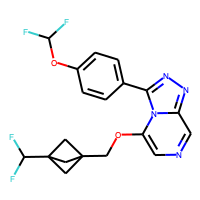
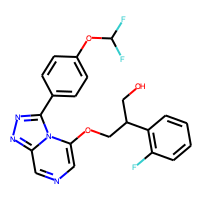
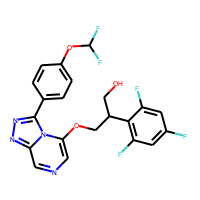
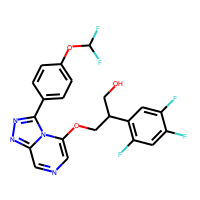
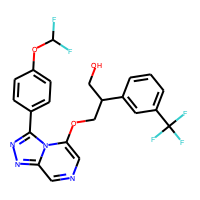

In [52]:
data_pred = pd.read_csv('predictions_Laksh.csv', header=0)

data_pred['Exscientia_predictions'] = data_pred['Exscientia_predictions'].astype(float)

# Target values

data_pred['ROMol'] = data_pred['SMILES'].apply(Chem.MolFromSmiles)

# Remove molecules that could not be parsed from SMILES
data_pred = data_pred[~data_pred.ROMol.isnull()]

data_pred['pIC50'] = calc_pIC50(data_pred['Exscientia_predictions'])

y_pred = data_pred['pIC50'].values
print(f"The data set contains {len(data_pred)} compounds")

data_pred.head(n=3)

data_val = pd.read_csv('validation_set.csv', header=0)
data_val['ROMol'] = data_val['SMILES'].apply(Chem.MolFromSmiles)

data_val = data_val[~data_val.ROMol.isnull()]

data_val['pIC50'] = calc_pIC50(data_val['Experimental (uM)'])

y_val = data_val['pIC50'].values
print(f"The data set contains {len(data_val)} compounds")

data_val.head()

/Users/btatsis/anaconda3/envs/comptoir/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:183: UserWarning: Truncating the list of molecules to be displayed to 20. Change the maxMols value to display more.
  % (maxMols))


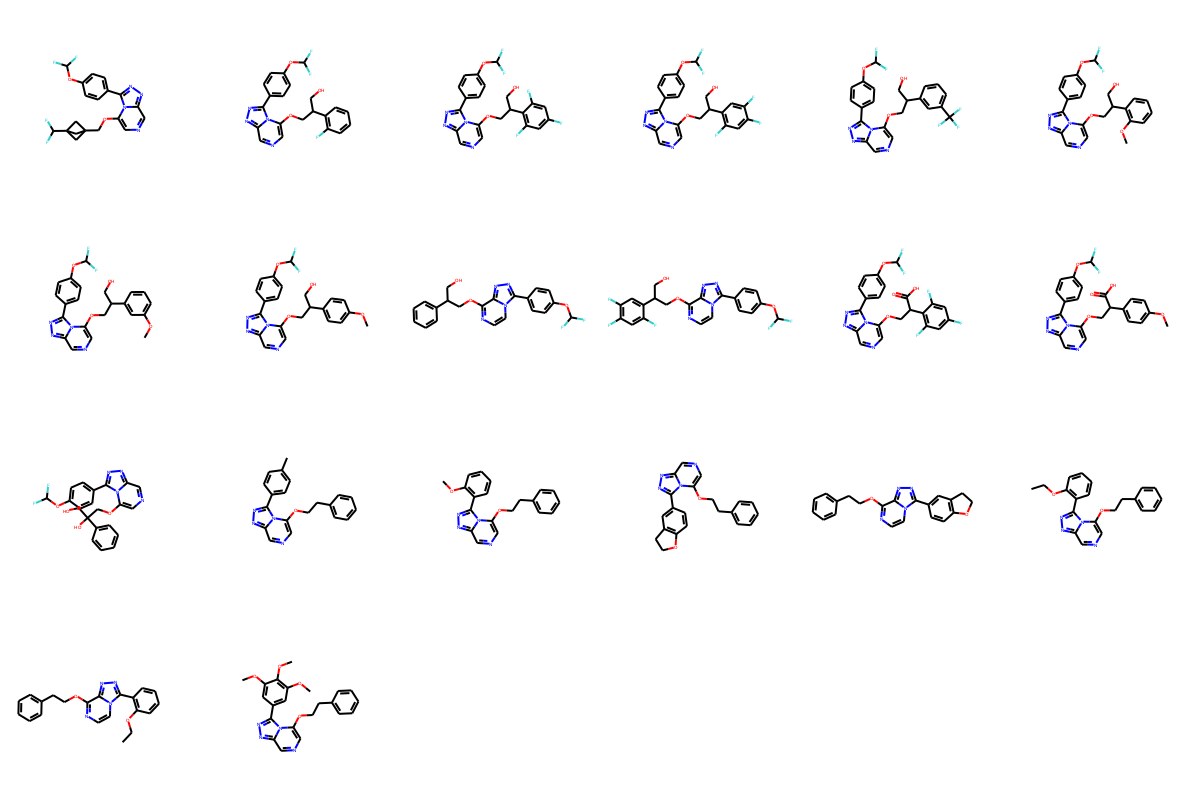

In [37]:
PandasTools.FrameToGridImage(data_pred, molsPerRow=6, legendsCol='', maxMols=20)

(33, 1024) (33,) (369, 1024) (369,)
(33, 1024) (33,) (369, 1024) (369,)
(402, 1024) (402,)
0.14947324797157402


<Figure size 432x288 with 0 Axes>

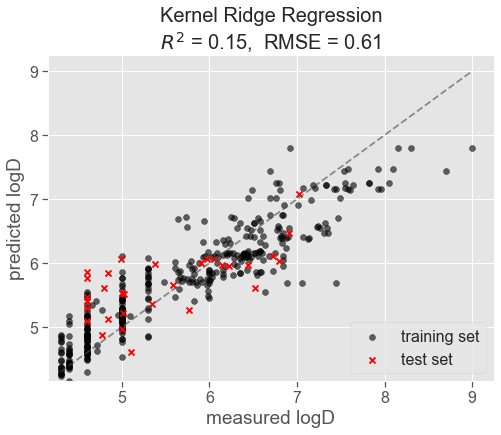

In [54]:
data_pred['fp_Morgan'] = data_pred['ROMol'].apply(Morgan_fingerprint)

X_pred = np.array(list(data_pred['fp_Morgan']))
print(X_pred.shape, y_pred.shape, X.shape, y.shape)

data_val['fp_Morgan'] = data_val['ROMol'].apply(Morgan_fingerprint)

X_val = np.array(list(data_val['fp_Morgan']))
print(X_val.shape, y_val.shape, X.shape, y.shape)

# These two lines are absolutely wrong!
#X_tol = np.concatenate((X, X_pred), axis=0)
#y_tol = np.concatenate((y, y_pred), axis=0)
print(X_tol.shape, y_tol.shape)

Best_KernelRidge.fit(X, y)

with open('b_kr.pkl', 'wb') as f:
    pickle.dump(Best_KernelRidge, f)
          
y_pred_train = Best_KernelRidge.predict(X)
y_pred_pred = Best_KernelRidge.predict(X_pred)

y_pred_val = Best_KernelRidge.predict(X_val)

r_square = r2_score(y_pred, y_pred_pred)
print(r_square)
rmse = mean_squared_error(y_val, y_pred_val) ** 0.5

# Call ploting function
fulltitle = "Kernel Ridge Regression" + "\n" + "$R^{2}$ = " + str("{:.2f}".format(r_square)) + ',  RMSE = ' + str("{:.2f}".format(rmse))
#fulltitle = f"Kernel Ridge Regression \n $R^{2}$ = {r_square:2.f}, RMSE = {rmse:.2f}"
plot_results(y_pred_train, y_pred_val, y, y_val, np.max(y), np.min(y), title=fulltitle, title1=name, figsize=(8,6))

#r_square_2 = r2_score(y_val, data_val['logD_CXN'])
#rmse_2 = mean_squared_error(y_val, data_val['logD_CXN']) ** 0.5#

# Call ploting function
#fulltitle = "ChemAxon" + "\n" + "$R^{2}$ = " + str("{:.2f}".format(r_square_2)) + ',  RMSE = ' + str("{:.2f}".format(rmse_2))
#plot_results(y_pred_train, data_val['logD_CXN'], y, y_val, np.max(y), np.min(y)-1, title=fulltitle, title1=name, figsize=(8,6))

### Failed attempt with Pytorch

Putting PyTorch into the mix!      
Please ignore :)

In [12]:
#Import libraries

import pprint
import argparse
import torch
import torch.optim as optim
from torch import nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
 
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import numpy as np

X_train = torch.from_numpy(X[:40])
X_test = torch.from_numpy(X[40:])
Y_train = torch.from_numpy(y[0:40])
Y_test = torch.from_numpy(y[40:])
print(X_train.size(),Y_train.size())
print(X_test.size(), Y_test.size())
 
class QSAR_mlp(nn.Module):
    def __init__(self):
        super(QSAR_mlp, self).__init__()
        self.fc1 = nn.Linear(2048, 524)
        self.fc2 = nn.Linear(524, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10,3)
    def forward(self, x):
        x = x.view(-1, 2048)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = F.relu(self.fc3(h2))
        output = F.sigmoid(self.fc4(h3))
        return output

torch.Size([40, 1024]) torch.Size([40])
torch.Size([14, 1024]) torch.Size([14])


In [16]:
model = QSAR_mlp()
print(model)

epochs = 5 
losses = []
optimizer = optim.Adam( model.parameters(), lr=0.005)
for epoch in range(epochs):
    data, target = Variable(X_train).float(), Variable(Y_train).float()
    print(data.size(), target.size())
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.cross_entropy(y_pred, target)
    print("Loss: {}".format(loss.data[0]))
    loss.backward()
    optimizer.step()
 
pred_y = model(Variable(X_test).float())
predicted = torch.max(pred_y, 1)[1]
 
for i in range(len(predicted)):
    print("pred:{}, target:{}".format(predicted.data[i], Y_test[i]))
 
print( "Accuracy: {}".format(sum(p==t for p,t in zip(predicted.data, Y_test))/len(Y_test)))

QSAR_mlp(
  (fc1): Linear(in_features=2048, out_features=524, bias=True)
  (fc2): Linear(in_features=524, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=3, bias=True)
)
torch.Size([40, 1024]) torch.Size([40])


ValueError: Expected input batch_size (20) to match target batch_size (40).

In [51]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.AllChem import  GetMorganFingerprintAsBitVect
import numpy as np
import pickle
import os

# Morgan fingerprints, length 1024 bits
def Morgan_fingerprint(mol):
    fp = np.zeros((1,))
    ConvertToNumpyArray(GetMorganFingerprintAsBitVect(mol, 2, nBits = 1024), fp)
    return fp

X = np.empty((0, 1024))

suppl = Chem.SDMolSupplier('val_set4_cxn.sdf')
for mol in suppl:
    X = np.append(X, [Morgan_fingerprint(mol)], axis=0)

if os.path.exists('b_kr.pkl'):
    with open('b_kr.pkl', 'rb') as pred:
        b_kr = pickle.load(pred)
        
y_pred = []
y_pred = b_kr.predict(X)

print(y_pred, y_pred.shape)

[1.17188835 1.59978104 1.30445671 2.19846153] (4,)
